In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
import pickle
from sklearn import model_selection, preprocessing, metrics
import scipy
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [83]:
train = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/kaggle/MSCI/dataset/train_Citeseq_truncated_512.pkl')
train = pd.DataFrame(train)
train.shape

(70988, 512)

In [84]:
test = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/kaggle/MSCI/dataset/test_Citeseq_truncated_512.pkl')
test = pd.DataFrame(test)
test.shape

(48663, 512)

In [97]:
class Adversarial_validator:

    def __init__(self, train, test, features, categoricals):
        self.train = train
        self.test = test
        self.features = features
        self.categoricals = categoricals
        self.union_df = self.train_test_union(self.train, self.test)
        self.cv = self.get_cv()
        self.models = []
        self.oof_pred = self.fit()
        self.report_plot()

    def fit(self):
        oof_pred = np.zeros((len(self.union_df), ))

        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_predict = self.union_df[self.features].iloc[
                train_idx], self.union_df[self.features].iloc[val_idx]
            y_train = self.union_df['target'][train_idx]
            train_set = self.convert_dataset(x_train, y_train)
            model = self.train_model(train_set)
            self.models.append(model)

            oof_pred[val_idx] = model.predict(
                x_predict).reshape(oof_pred[val_idx].shape)
        self.union_df['prediction'] = oof_pred
        return oof_pred

    def train_test_union(self, train, test):
        train['target'] = 0
        test['target'] = 1
        return pd.concat([train, test], axis=0).reset_index(drop=True)

    def get_cv(self):
        cv = StratifiedKFold(n_splits=5,
                             shuffle=True, random_state=42)

        return cv.split(self.union_df, self.union_df['target'])

    def convert_dataset(self, X, y):
        return lgb.Dataset(X, label=y, categorical_feature=self.categoricals)

    def train_model(self, train_set):
        return lgb.train(self.get_params(), train_set)

    def get_params(self):
        param = {'num_leaves': 50,
                 'num_round': 100,
                 'min_data_in_leaf': 30,
                 'objective': 'binary',
                 'max_depth': 5,
                 'learning_rate': 0.2,
                 'min_child_samples': 20,
                 'boosting': 'gbdt',
                 'feature_fraction': 0.9,
                 'bagging_freq': 1,
                 'bagging_fraction': 0.9,
                 'bagging_seed': 44,
                 'verbose_eval': 50,
                 'metric': 'auc',
                 'verbosity': -1}
        return param

    def report_plot(self):
        fig, ax = plt.subplots(figsize=(16, 12))
        plt.subplot(2, 2, 1)
        self.plot_feature_importance()
        plt.subplot(2, 2, 2)
        self.plot_roc_curve()
        plt.subplot(2, 2, 3)
        plt.hist(self.union_df['target'] - self.oof_pred)
        plt.title('Distribution of errors')
        plt.subplot(2, 2, 4)
        plt.hist(np.random.choice(self.oof_pred, 1000, False))
        plt.title('Distribution of oof predictions')

    def get_feature_importance(self):
        n = len(self.models)
        feature_imp_df = pd.DataFrame()
        for i in range(n):
            tmp = pd.DataFrame(zip(self.models[i].feature_importance(
            ), self.features), columns=['Value', 'Feature'])
            tmp['n_models'] = i
            feature_imp_df = pd.concat([feature_imp_df, tmp])
            del tmp
        self.feature_importance = feature_imp_df
        return feature_imp_df

    def plot_feature_importance(self, n=20):
        imp_df = self.get_feature_importance().groupby(
            ['Feature'])[['Value']].mean().reset_index(False)
        imp_top_df = imp_df.sort_values('Value', ascending=False).head(n)
        sns.barplot(data=imp_top_df, x='Value', y='Feature', orient='h')
        plt.title('Feature importances')

    def plot_roc_curve(self):
        fpr, tpr, thresholds = metrics.roc_curve(
            self.union_df['target'], self.oof_pred)
        auc = metrics.auc(fpr, tpr)

        plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' % auc)
        plt.legend()
        plt.title('ROC curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


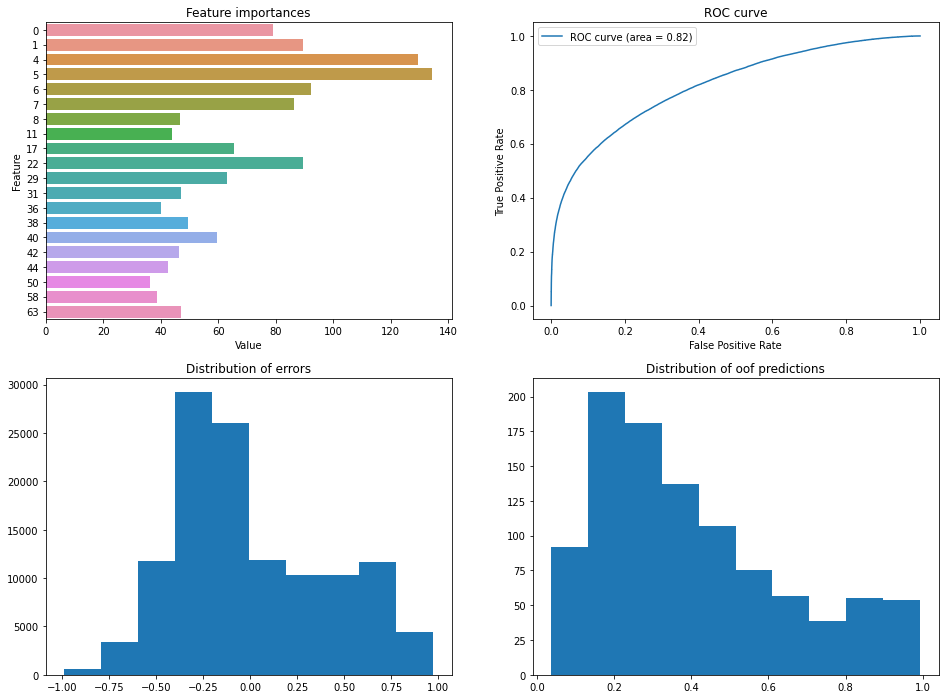

In [98]:
adv = Adversarial_validator(train, test, features=train.columns, categoricals=None)

In [87]:
imp_df = adv.get_feature_importance().groupby(
    ['Feature'])[['Value']].mean().reset_index(False)
imp_top_df = imp_df.sort_values('Value', ascending=False).head(50)

In [ ]:
imp_top_df.head(25)

In [89]:
imp_top_df[imp_top_df.Value>=50].Feature.values

array([13, 20,  2, 23, 24, 18,  9, 15, 35, 19,  3, 25, 21, 12, 14, 10, 26,
       16, 30])

In [90]:
drop_clm2 = ['target']

In [91]:
drop_clm2 += imp_top_df[imp_top_df.Value>=50].Feature.values.tolist()

In [92]:
train = train.drop(columns=drop_clm2)

In [93]:
test = test.drop(columns=drop_clm2)

In [94]:
train.shape,test.shape

((70988, 493), (48663, 493))

In [69]:
train = train.drop(columns='target')

In [71]:
test = test.drop(columns='target')

In [72]:
train.shape,test.shape

((70988, 462), (48663, 462))

In [75]:
train.head()

,1,32,34,37,39,41,45,46,47,48,...,502,503,504,505,506,507,508,509,510,511
0,-22.561085,-0.590249,1.949430,1.079616,-0.508982,-0.942441,-3.226485,3.200755,0.886522,-3.813458,...,-4.047112,2.983886,-1.958393,-3.030636,1.153874,-2.146154,-5.356063,-1.906279,0.931249,-2.344807
1,-31.366274,-4.341890,3.464648,-6.051026,0.394088,4.431827,0.014642,4.001431,2.691066,-4.327451,...,-1.495667,-2.994017,-4.918020,-1.640752,1.523859,-5.691554,2.024794,-3.961086,2.330351,-3.329708
2,9.889734,0.637941,-4.990311,3.875904,-1.916767,-2.114729,-1.868782,0.488351,-2.772135,1.332927,...,-5.144400,0.056900,1.733092,-1.679243,-3.017898,2.905046,-0.459892,2.346487,5.753773,0.076685
3,16.119389,1.367881,-2.162637,0.673180,-2.827760,-2.129568,3.826687,2.312301,-1.351758,-3.626963,...,-0.034228,0.581569,-2.005979,-0.664763,-0.333772,1.418177,0.055124,-2.750523,2.586551,-1.458870
4,41.994110,-1.658649,2.960676,-8.916211,0.801056,0.589890,0.429288,-2.203425,-2.141642,-0.914994,...,-4.554404,2.187938,-1.295304,-2.032076,-2.902044,3.809628,1.783741,-0.630009,-2.287475,2.292157


In [79]:
with open(f"/content/drive/MyDrive/Colab Notebooks/kaggle/MSCI/dataset/train_Citeseq_svdtoadv_truncated_462.pkl", "wb") as f:
    pickle.dump(train.values, f)

In [80]:
with open(f"/content/drive/MyDrive/Colab Notebooks/kaggle/MSCI/dataset/test_Citeseq_svdtoadv_truncated_462.pkl", "wb") as f:
    pickle.dump(test.values, f)